In [1]:
%matplotlib notebook
import capo
import aipy as ap
import numpy as np
from matplotlib.colors import SymLogNorm, LogNorm
from matplotlib.pyplot import *
from pyuvdata import UVData
import hera_cal

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
rcParams.update({'font.size':14})

In [3]:
def covariance(x1, x2=None, axis=(-1)):
    if x2 is None:
        x2 = x1.copy()
    X1 = np.array(x1, dtype=np.complex)
    X2 = np.array(x2, dtype=np.complex)
    X1 -= X1.mean(axis=axis, keepdims=True)#[slice(None), np.newaxis]
    X2 -= X2.mean(axis=axis, keepdims=True)#[slice(None), np.newaxis]    
    norm = float(X1.shape[axis] - 1)
    cov = np.dot(X1, X2.T.conj())/norm
    return cov.squeeze()

In [4]:
def correlation_matrix(arr_in, axis=-1):
    if np.ndim(arr_in) != 2:
        arr_in = arr_in.reshape(arr_in.shape[0], -1)
    corr_matrix = covariance(arr_in)
    autos = np.sqrt(np.diag(corr_matrix).copy())
    corr_matrix /= autos[:,None]    
    corr_matrix /= autos[None,:]
    return corr_matrix

In [13]:
CAL = 'psa6240_v003'

In [9]:
even_filenames= !/home/mkolopanis/src/anaconda/envs/HERA/bin/lst_select.py -C psa6240_v003\
                /home/mkolopanis/psa64/lstbin_psa64_data_optimal_23Jan2017/odd/sep0,1/lst*.uvGAL \
                --ra=.5_8.5
even_file_string= ' '.join(even_filenames)

In [10]:
data_info, data, data_flgs = capo.miriad.read_files(even_filenames, 'cross','I')
lsts = data_info['lsts']
freqs = data_info['freqs']
bls = data.keys()


In [14]:
aa = ap.cal.get_aa(CAL, freqs)
___, conj = capo.red.group_redundant_bls(aa.ant_layout)

In [15]:
chans =[0,203]
chan_range = np.arange(203)[chans[0]:chans[-1]]
shape = (len(bls), data[bls[0]]['I'][:,chan_range].shape[1], data[bls[0]]['I'].shape[0])
data_array = np.zeros(shape, dtype=np.complex)

for cnt, bl in enumerate(bls):
    if conj[bl]:
        data_array[cnt] = np.conj(data[bl]['I'][:,chan_range].T)
    else:
        data_array[cnt] = data[bl]['I'][:,chan_range].T
        

<IPython.core.display.Javascript object>


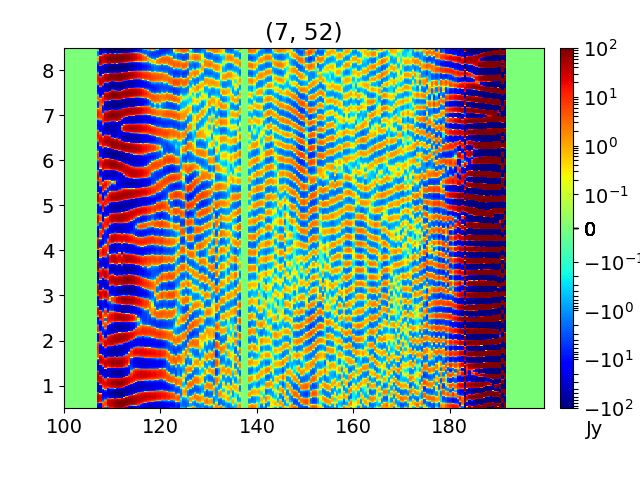

In [16]:
fig, ax = subplots(1)
x_lim = [freqs[0]*1e3, freqs[-1]*1e3]
y_lim = [lsts[0] *12./np.pi, lsts[-1]*12./np.pi]
# norm = LogNorm(vmin=1e-2, vmax=1e2)
norm = SymLogNorm(vmin=-1e2, vmax=1e2, linthresh=1e-1)
cmap='jet'
im = ax.pcolorfast(x_lim, y_lim, np.real(data_array[0].T), norm=norm, cmap=cmap)
ax.set_title(bls[0])
fig.subplots_adjust(wspace=.1, right=.85, left=.1, top=.9, bottom=.15)
cbax = fig.add_axes([.875,.15,.02,.75])
cbar=fig.colorbar(im, cax=cbax,)#, orientation='horizontal')#, label='[mK]$^{2}$ [$h$ Mpc$^{-1}$]$^{-3}$')
cbar = cbar.ax.text(2,-0.075,'Jy',rotation=0)

In [17]:
data_correlation = correlation_matrix(data_array)

<IPython.core.display.Javascript object>


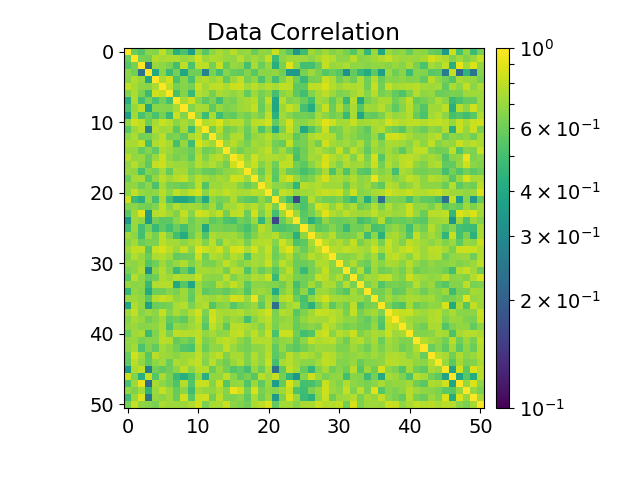

In [18]:
fig, ax = subplots(1)
im=ax.imshow(data_correlation.real,
             norm=LogNorm(vmin=1e-1, vmax=1))
#              norm=SymLogNorm(vmin=-1, vmax=1, linthresh=1e-2))
#          vmin=.5, vmax=1)
ax.set_title('Data Correlation')
fig.subplots_adjust(wspace=0, right=.85, left=.1, top=.9, bottom=.15)
cbax = fig.add_axes([.775,.15,.02,.75])
cbar=fig.colorbar(im, cax=cbax)#, orientation='horizontal')#, label='[mK]$^{2}$ [$h$ Mpc$^{-1}$]$^{-3}$')


In [7]:
# np.array(bls)[np.array([3,8,9,31,34,38])]
np.array(bls)[np.array([3,21, 15,25,34,36,46])]
# np.array(bls)[np.array([48,7,15,17])]

NameError: name 'bls' is not defined

In [19]:
UV = UVData()
UV.read_uvfits('/home/mkolopanis/hera_sims/project_HERA_128/dither_gleam_64_150_150_0/simdata/test-noiseless.uvfits')
aa1 = hera_cal.utils.get_aa_from_uv(UV)
aa1_info = hera_cal.omni.aa_to_info(aa1)
reds = aa1_info.get_reds()

antenna_diameters is not set. Using known values for HERA.


In [20]:
uv_bls = [tuple(ij) for ij in zip(*UV.baseline_to_antnums(UV.baseline_array))]
shape = (UV.Nbls, UV.Nfreqs, UV.Ntimes)
# uv_data_array = np.zeros(shape, dtype=np.complex)
num_bls = [ len(gp) for gp in reds]
longest = np.argmax(num_bls).squeeze()

uv_data_array = []
for  gp in reds:
    gp_array = []
    for bl in gp:
        try:
            gp_array.append(UV.get_data(bl))
        except(KeyError):
            try:
                gp_array.append(UV.get_data(bl[::-1]))
            except(KeyError):
                pass
    uv_data_array.append(np.array(gp_array))
uv_data_array = np.array(uv_data_array)

In [21]:
uv_correlation =correlation_matrix(uv_data_array[longest])

<IPython.core.display.Javascript object>


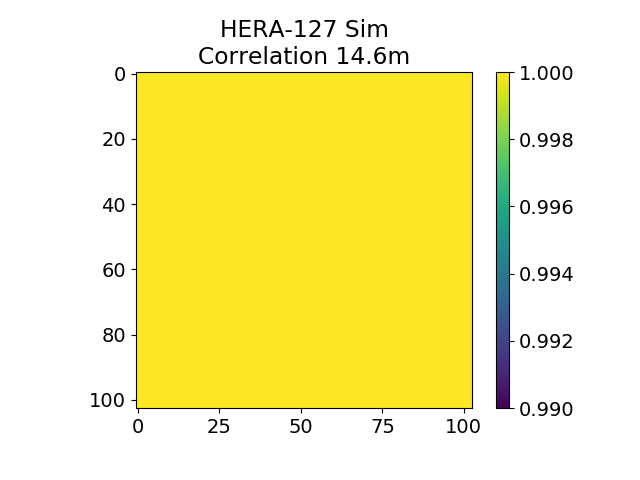

In [22]:
fig, ax = subplots(1)
im=ax.imshow(uv_correlation.real,
#              norm=LogNorm(vmin=5e-1, vmax=7e-1))
         vmin=.99, vmax=1)
bl_len = np.linalg.norm(aa1.get_baseline(*reds[longest][0]) )* 3e8/1e9
ax.set_title('HERA-127 Sim\nCorrelation {0:.1f}m'.format(bl_len))
fig.subplots_adjust(wspace=0, right=.85, left=.1, top=.85, bottom=.15)
cbax = fig.add_axes([.775,.15,.02,.7])
cbar=fig.colorbar(im, cax=cbax)#, orientation='horizontal')#, label='[mK]$^{2}$ [$h$ Mpc$^{-1}$]$^{-3}$')


In [23]:
aa1.get_baseline(*reds[312][0]) * 3e8/1e9

array([-95.39938552,  -4.09314222,  -6.88750193])

In [24]:
len(reds[30])

18

In [25]:
base.

SyntaxError: invalid syntax (<ipython-input-25-3d3350df3e7f>, line 1)

In [26]:
len(reds)

555